## Model Calibration

The main goal of this project is to find implied volatilities using a Neural Network trained with a dataset derived from the application of the Black-Scholes formula for option pricing. You are asked to:
* Train a neural network to determine implied volatilities from a set of call and put options.
* Plot the "volatility smile" (volatility vs option strike).

The input parameters are:
* market quotes of a set of puts and calls;
* USD Libor rate;
* historical series and current price of the underlying asset.

In the training process try to optimize the network architecture by both checking configurations with 1,2 and 3 hidden layers and different number of epochs (avoiding overfitting) with the goal of reaching an accuracy (MSE) of about 1e-4. Assume also the following ranged for strike and sigma in creating the training sample:
* K = [105, 190]
* sigma = [0.2, 0.4]

### Notes and Hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework of the neural networks. The code should be well explained and should use as much as possible the modules developed during the course.

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
import numpy as np

strike_range = np.arange(105, 190, 0.01)
sigma_range = np.arange(0.2, 0.4, 0.0001)
r = 0.0004
S0 = 149.5
ttm = 0.5

## Call

In [ ]:
import numpy as np
import pandas as pd
from finmarkets import call

d = {"K":[], "vol":[], "price":[]}

for K in strike_range:
    for sigma in sigma_range:
        d["K"].append(K)
        d["vol"].append(sigma)
        d['price'].append(call(S0, K, r, sigma, 0.5))

df = pd.DataFrame(d)
df.to_csv('/content/drive/MyDrive/finance_course/Projects/training_sample_call_proj_9.csv')

In [ ]:
import numpy as np
import pandas as pd
from finmarkets import call

df_c = pd.DataFrame()
K, sigma = np.meshgrid(strike_range, sigma_range)
NT = np.product(K.shape)
df_c['K'] = np.reshape(K, NT)
df_c['vol'] = np.reshape(sigma, NT)
df_c['price'] = call(S0, df_c['K'], r, df_c['vol'], ttm)

#df.to_csv('/content/drive/MyDrive/finance_course/Projects/training_sample_call_proj_9.csv', index=None)

In [ ]:
import pandas as pd

df_c = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/training_sample_call_proj_9.csv")
print (df_c.describe())

                  K           vol         price
count  1.700000e+06  1.700000e+06  1.700000e+06
mean   1.474950e+02  2.995000e-01  1.719474e+01
std    2.453739e+01  5.773432e-02  1.272991e+01
min    1.050000e+02  2.000000e-01  4.421206e-01
25%    1.262475e+02  2.497500e-01  6.088642e+00
50%    1.474950e+02  2.995000e-01  1.378690e+01
75%    1.687425e+02  3.492500e-01  2.701128e+01
max    1.899900e+02  3.990000e-01  4.628553e+01


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x = df_c[['K', 'price']]
y = df_c[['vol']]
x_scale_c = MinMaxScaler()
y_scale_c = MinMaxScaler()
x_scaled_c = x_scale_c.fit_transform(x)
y_scaled_c = y_scale_c.fit_transform(y)
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_scaled_c, y_scaled_c, test_size=0.2)

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def baseModel():
  model = Sequential()
  model.add(Dense(20, input_dim=2, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='mse', optimizer='adam')
  return model 

earlyStop = EarlyStopping(monitor='loss', mode='min', patience=30)
results = []
for i in range(1):
  model = baseModel()
  model.fit(x_train_c, y_train_c, epochs=100, batch_size=250000, verbose=1)#, callbacks=[earlyStop])
  loss = model.history.history['loss']
  results.append(loss[-1])

Epoch 1/100
55/55 [==============================] - 6s 89ms/step - loss: 0.3335
Epoch 2/100
55/55 [==============================] - 5s 87ms/step - loss: 0.3335
Epoch 3/100
55/55 [==============================] - 5s 87ms/step - loss: 0.3335
Epoch 4/100
55/55 [==============================] - 5s 90ms/step - loss: 0.3335
Epoch 5/100
55/55 [==============================] - 5s 88ms/step - loss: 0.3335
Epoch 6/100
41/55 [=====================>........] - ETA: 1s - loss: 0.3335

KeyboardInterrupt: ignored

3.071737592108548e-05


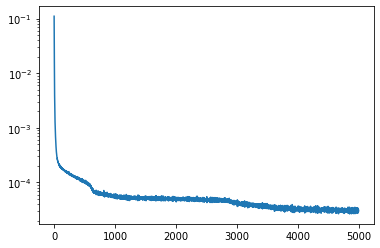

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print (np.mean(results))

plt.plot(loss)
plt.yscale('log')
plt.show()

In [ ]:
model_c.save("/content/drive/MyDrive/finance_course/Projects/call_proj9")

In [ ]:
from tensorflow.keras.models import load_model
from finmarkets import call

model_c = load_model("/content/drive/MyDrive/finance_course/Projects/call_proj9")

Xp = x_scale_c.transform([[105.1, 45.]])
res = model_c.predict(Xp)
vol = y_scale_c.inverse_transform(res)
print (Xp)
print (res)
print (vol[0][0])
print (call(S0, 105, r, vol[0][0], ttm))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


1/1 [==============================] - 0s 63ms/step
[[0.00117661 0.97195831]]
[[0.77671444]]
0.3545662
45.64105701558495


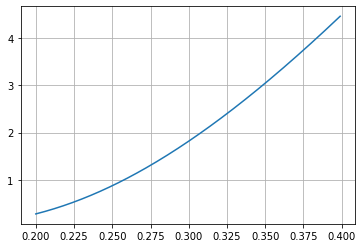

In [ ]:
import matplotlib.pyplot as plt

s = sigma_range
plt.plot(s, call(S0, 105, r, s, ttm))
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

#temp = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/call_put.csv")
temp = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/call_put.csv")
calls = temp[temp['type']=='call']
pairs = calls.loc[:, ['strike', 'price']].values

pairs_scaled = x_scale_c.transform(pairs)

implied_vol = y_scale_c.inverse_transform(model_c.predict(pairs_scaled))

print (implied_vol)

1/1 [==============================] - 0s 89ms/step
[[0.36367154]
 [0.3420001 ]
 [0.33064815]
 [0.30817023]
 [0.28479108]
 [0.2684157 ]
 [0.24261893]
 [0.23305371]
 [0.21978873]
 [0.22229701]
 [0.23835222]
 [0.25139514]
 [0.27316746]
 [0.2934479 ]
 [0.30178392]
 [0.3163724 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


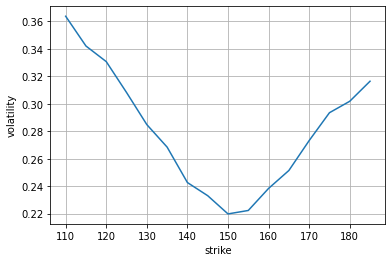

In [ ]:
from matplotlib import pyplot as plt

plt.plot(pairs[:, 0], implied_vol[:, 0])
plt.xlabel("strike")
plt.ylabel("volatility")
plt.grid(True)
plt.show()

### Individual prediction errors and 3D Plotting 

Still using the "best" architecture (the one with lower MSE) let's now present the problem related to some specific units. 

For each individual prediction compute the error according to: abs$(\frac{predicted - real}{real})$ 

### Call Options case 

The following lines of code try to illustrate this issue repeating some step: 

In [ ]:
X_transf = x_scale_c.transform(df_c[['K', 'price']])
vol_preds = y_scale_c.inverse_transform(model_c.predict(X_transf))
df_c['price_pred'] = call(S0, df_c['K'],  r, vol_preds[:, 0], ttm)
df_c['err_price'] = (df_c['price'] - df_c['price_pred'])/df_c['price']*100
df_c['abs_err_price'] = df_c['price'] - df_c['price_pred']
df_c['vol_pred'] = vol_preds[:, 0]
df_c['err_vol'] = (df_c['vol'] - df_c['vol_pred'])/df_c['vol'] 

print (df_c.head())

53125/53125 [==============================] - 76s 1ms/step
        K  vol      price  price_pred  err_price  abs_err_price  vol_pred  \
0  105.00  0.2  44.556445   45.375535  -1.838321      -0.819090  0.332749   
1  105.01  0.2  44.546522   45.365625  -1.838759      -0.819103  0.332683   
2  105.02  0.2  44.536600   45.355717  -1.839200      -0.819117  0.332618   
3  105.03  0.2  44.526678   45.345808  -1.839639      -0.819130  0.332553   
4  105.04  0.2  44.516756   45.335900  -1.840080      -0.819144  0.332488   

    err_vol  
0 -0.663744  
1 -0.663417  
2 -0.663091  
3 -0.662765  
4 -0.662439  


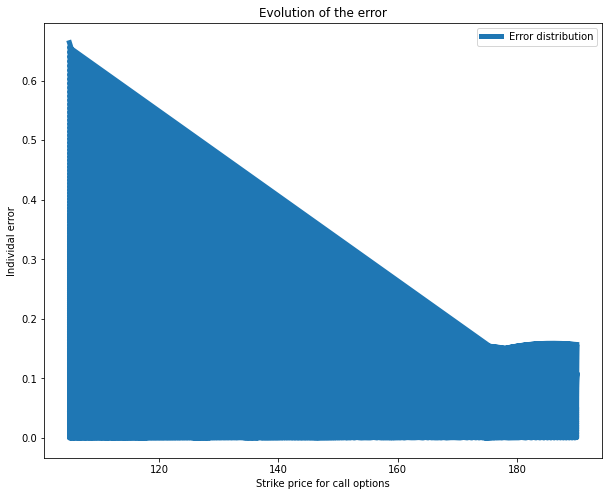

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))

plt.plot(df_c['K'], np.abs(df_c['err_vol']), linewidth = 5, label = "Error distribution")

plt.title("Evolution of the error")
plt.xlabel("Strike price for call options")
plt.ylabel("Individal error")
plt.legend()
plt.show()


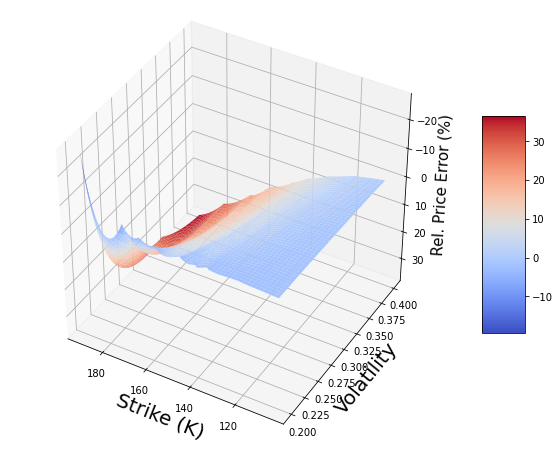

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))

X, Y = np.meshgrid(strike_range, sigma_range)

ax = fig.gca(projection='3d')

Z = df_c['err_price'].values
Z = Z.reshape(len(sigma_range), len(strike_range))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.set_zlim(-.5, 0.5)

ax.set_xlabel("Strike (K)", fontsize = 20)
ax.set_ylabel("Volatility", fontsize = 20)
ax.set_zlabel("Rel. Price Error (%)", fontsize= 15)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(-140, 60)
plt.show()

--- 

## Put

In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame()
K, sigma = np.meshgrid(np.arange(*strike_range, 0.01), np.arange(*sigma_range, 0.001))
NT = np.product(K.shape)
df['K'] = np.reshape(K, NT)
df['vol'] = np.reshape(sigma, NT)
df['price'] = put(S0, df['K'], r, df['vol'], ttm)

df.to_csv('/content/drive/MyDrive/finance_course/Projects/training_sample_put_proj_9.csv')

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/training_sample_put_proj_9.csv")
print (df.describe())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x = df[['K', 'price']]
y = df['vol'].values
x_scale_p = MinMaxScaler()
y_scale_p = MinMaxScaler()
x_scaled = x_scale_p.fit_transform(x)
y_scaled = y_scale_p.fit_transform(y.reshape(-1, 1))
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x_scaled, y_scaled, test_size=0.2)

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def baseModel():
  model = Sequential()
  model.add(Dense(20, input_dim=2, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='mse', optimizer='adam')
  return model 

earlyStop = EarlyStopping(monitor='loss', mode='min', patience=30)
results = []
for i in range(1):
  model = baseModel()
  model.fit(x_train_p, y_train_p, epochs=300, batch_size=1000, verbose=1, callbacks=[earlyStop])
  loss = model.history.history['loss']
  results.append(loss)

In [ ]:
model.save("/content/drive/MyDrive/finance_course/Projects/put_proj9")

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

model_p = load_model("/content/drive/MyDrive/finance_course/Projects/put_proj9")
#temp = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/call_put.csv")
temp = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/call_put.csv")

puts = temp[temp['type']=='put'].copy()
pairs = puts.loc[:, ['strike', 'price']].values[:]
pairs_scaled = x_scale_p.transform(pairs)
implied_vol = y_scale_p.inverse_transform(model_p.predict(pairs_scaled))

print (implied_vol)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


1/1 [==============================] - 0s 63ms/step
[[0.38521636]
 [0.36746833]
 [0.3489662 ]
 [0.32600754]
 [0.29804018]
 [0.2647064 ]
 [0.23988657]
 [0.2162455 ]
 [0.2045352 ]
 [0.21485573]
 [0.22717316]
 [0.24754089]
 [0.27891877]
 [0.29470176]
 [0.33728188]
 [0.35209042]]


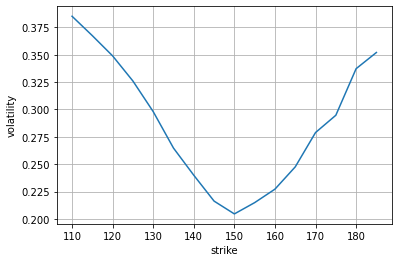

In [ ]:
from matplotlib import pyplot as plt

plt.plot(pairs[:, 0], implied_vol[:, 0])
plt.xlabel("strike")
plt.ylabel("volatility")
plt.grid(True)
plt.show()

### Put options case 

In [ ]:
trainer_plot_p = FinNN("ANN") #Instanciating a class instance

trainer_plot_p.setData(x_p,y_p,test_size = 0.20)
trainer_plot_p.normalize()

In [ ]:
trainer_plot_p.addInputLayer(inputs=2, neurons=30, activation='relu') 
trainer_plot_p.addHiddenLayer(neurons=15, activation='relu')
trainer_plot_p.addHiddenLayer(neurons=5, activation='relu')
trainer_plot_p.addOutputLayer(outputs=1) #The implied sigma


trainer_plot_p.compileModel(loss='mse', opt='adam')
 
trainer_plot_p.fit(epochs=10000, verbose=0)

trainer_plot_p.evaluate()

In [ ]:
data_p = {'strikes':[], 'prices':[], 'err':[]} #Dict with lists as values, which will be passed into the following DF

df_p = pd.DataFrame(data_p)

err2_p = np.zeros(shape=(len(sigmas), len(strikes_p))) #An array object to be used as dependent variable in plotting

for ix, sigma in enumerate(sigmas):
    for iy, strike in enumerate(strikes_p):
        price = put(underlying, strike, 0.00034, sigma, 1)
        rv = np.array([[strike, price]])
        pred = trainer_plot_p.predict(rv)[0][0]
        err = abs(pred - sigma)/sigma
        
        price2 = put(underlying, strike, 0.00034, pred, 1)
        
        err2_p[ix, iy] = abs(price-price2)/price
        
        ls = {"strikes":strike, "prices":price, "err":err}
        df_p = df_p.append(ls, ignore_index=True)

In [ ]:
df_p

,strikes,prices,err
0,7.0,0.019866,0.055151
1,7.1,0.022134,0.046140
2,7.2,0.024598,0.037662
3,7.3,0.027269,0.029746
4,7.4,0.030159,0.023036
...,...,...,...
11885,35.5,20.298778,0.000980
11886,35.6,20.389435,0.001221
11887,35.7,20.480149,0.001473
11888,35.8,20.570922,0.001739


- In order to represent these results in a proper 2D plot, it's better to re-sort according to the strikes this dataframe: 

In [ ]:
sorted_df_p = pd.concat([df_p[df_p["strikes"] == strike] for strike in np.arange(7.0,36.0,0.1)], axis =0, ignore_index=True)
sorted_df_p 

,strikes,prices,err
0,7.0,0.019866,0.055151
1,7.0,0.023727,0.039627
2,7.0,0.028051,0.026038
3,7.0,0.032856,0.014292
4,7.0,0.038155,0.004300
...,...,...,...
11885,35.9,20.430934,0.002752
11886,35.9,20.487777,0.002369
11887,35.9,20.545209,0.002126
11888,35.9,20.603208,0.002011


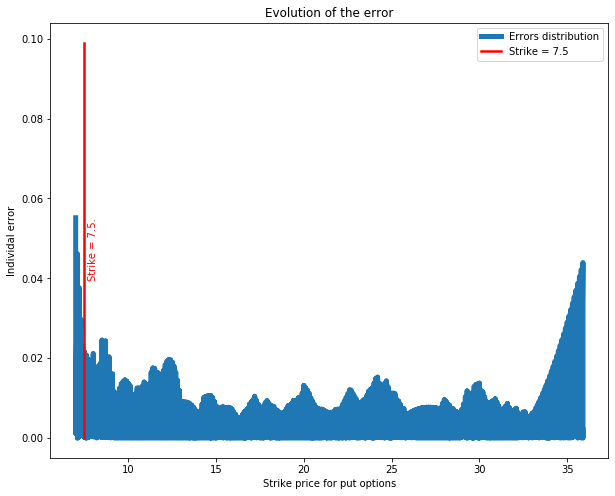

In [ ]:
fig = plt.figure(figsize=(10,8))

plt.plot(sorted_df_p["strikes"], sorted_df_p["err"], linewidth = 5, label = "Errors distribution")
plt.plot([7.5 for  _ in range(len(np.arange(0,0.1,0.001)))], np.arange(0,0.1,0.001), linewidth =2.5, color = 'r', label = "Strike = 7.5")

plt.title("Evolution of the error")
plt.xlabel("Strike price for put options")
plt.ylabel("Individal error")

plt.text(7.7, 0.04, "Strike = 7.5.", rotation=90, color = 'r')

plt.legend()
plt.show()


- Let's now implement it into a proper 3D plot: 

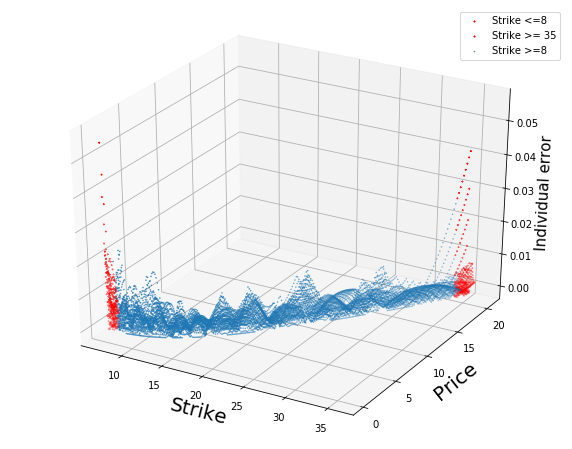

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.scatter(sorted_df_p.iloc[:400,0].values, sorted_df_p.iloc[:400,1].values, sorted_df_p.iloc[:400,2].values, #I split in two sub-groups to highlight them with different colors 
           marker="x",color = 'r', s=1, label = "Strike <=8")

ax.scatter(sorted_df_p.iloc[-400:,0].values, sorted_df_p.iloc[-400:,1].values, sorted_df_p.iloc[-400:,2].values, #I split in two sub-groups to highlight them with different colors 
           marker="x",color = 'r', s=1, label = "Strike >= 35")

ax.scatter(sorted_df_p.iloc[400:-400,0].values, sorted_df_p.iloc[400:-400,1].values, sorted_df_p.iloc[400:-400,2].values,
           marker=".", s=1, label = "Strike >=8")

ax.set_xlabel("Strike", fontsize = 20)
ax.set_ylabel("Price", fontsize = 20)
ax.set_zlabel("Individual error", fontsize= 15)


ax.legend()
plt.show()

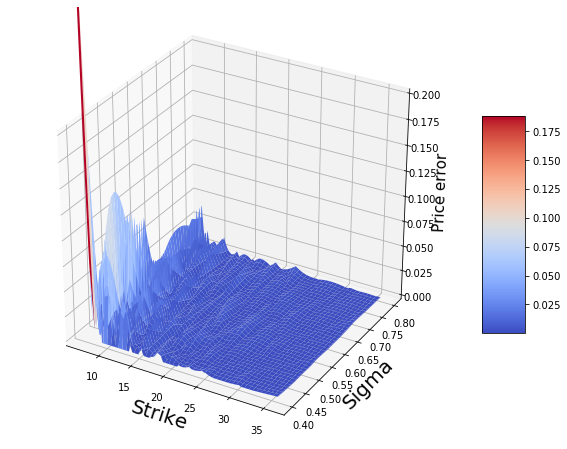

In [ ]:
from matplotlib import cm


fig = plt.figure(figsize=(10,8))


X, Y = np.meshgrid(strikes_p, sigmas)

ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, err2_p, cmap=cm.coolwarm)
ax.set_zlim(0, 0.2)

ax.set_xlabel("Strike", fontsize = 20)
ax.set_ylabel("Sigma", fontsize = 20)
ax.set_zlabel("Price error", fontsize= 15)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

This architecture gives us an error in terms of difference between the input B&S price and the implied one. As we can observe, we obtained higher errors for low strikes in this teaching procedure (reaching a relevant peak low strike low sigma coordinate).
This would provide us some insights on the prediction task we will examine in _[section 2]_.

# 3) Our model predictions with real observed inputs.<a name="3"></a> 

From now on, we are going to make some reasonments about the underlying historical volatility computation and the feasibility (or not) of using it as a substitute of the implied one. 

From the general theory, we know the historical volatility to be the realized volatility of the underlying asset (for which we have all the past price records) over a previous period of time, determined by measuring the deviation from the underlying asset mean over that period. Since it looks at past prices, it is called _backward looking approach._

On the other hand, the implied volatility follows a _forward looking idea._ For this reason it's interpreted as the market expectation for the future volatility of the underlying, implied by the price of the option according to the _(B&S) model calibration_ idea.  


Is a backward looking consistent and useful for our purposes? To answer this we are going to compute the historical volatility following one of the most common approaches: the _equally weighted (moving) standard deviation._

Then, we are going to compare the associated theoretical B&S prices (with input those results) with the actual ones. 

First of all, let's use the available data set for underlying historical prices. 

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/finance_course/Projects/proj_9.csv", index_col = 0)
data['ret'] = data.pct_change()
historical_sigma = np.std(data['ret'])*np.sqrt(252)
print (historical_sigma)

0.194736993402709


In [ ]:
for i in range(len(prediction_sample_c)):
    
    prediction_sample_c.iloc[i,-1] =  call(S0, 
                                        prediction_sample_c.iloc[i,3], #Strike price in our frame (column4)
                                        r,
                                        historical_sigma,
                                        ttm)
    

for i in range(len(prediction_sample_p)):
    
    prediction_sample_p.iloc[i,-1] =  put(S0, 
                                        prediction_sample_p.iloc[i,3], #Strike price in our frame (column4)
                                        r,
                                        historical_sigma,
                                        ttm)

In [ ]:
prediction_sample_p

,Moneyness,Rate,Price,Strike,Label,Implied Sigma,Historical Vol,B&S Hist Vol
type,,,,,,,,
put,2.266667,0.00034,0.39,7.5,OTM,0.666944,0.588434,0.240867
put,1.700000,0.00034,0.87,10.0,OTM,0.622202,0.588434,0.747033
put,1.360000,0.00034,1.61,12.5,OTM,0.589717,0.588434,1.599908
put,1.133333,0.00034,2.69,15.0,OTM,0.574773,0.588434,2.780744
put,0.971429,0.00034,4.03,17.5,ITM,0.554602,0.588434,4.242718
put,0.850000,0.00034,5.63,20.0,ITM,0.541835,0.588434,5.933371
put,0.755556,0.00034,7.40,22.5,ITM,0.526757,0.588434,7.804765
put,0.680000,0.00034,9.38,25.0,ITM,0.519401,0.588434,9.816804
put,0.566667,0.00034,13.70,30.0,ITM,0.499294,0.588434,14.141633


**Final comments**

As we can see, the price tends to differ more when the implied sigma is quite different from the historical one. 

This is a clear mathematical consequence of the B&S formula application, with the put option price increasing in volatility (from the Vega-Greeks > 0). 

For this reason, we can conclude that the underlying historical volatility, can't be a good proxy to compute the theoretical B&S price, with biased results with respect to the observed prices. 

# 4) Options greeks: delta as proxy of likelihood <a name="4"></a>

**Final question:** "Finally you are asked to estimate the probability that the lowest strike put will expire in the money using the option delta as proxy for the probability."

To solve this kind of question we decided to follow the simplest way, i.e. we know that from the general theory (getting the derivatives of the B&S put and call pricing formulas with respect to the underlying) the _Deltas_ are respectively given by: 

1) $\Delta_C$ $=$ $\frac{\partial C}{\partial S}$ $=$ $N{(d_1)}$

2) $\Delta_P$ $=$ $\frac{\partial P}{\partial S}$ $=$ $-N{(-d_1)}$ $=$ $N{(d_1)} - 1$

For this reason we decided to create 2 different utility functions which rely on the _finmarkets_ module functions (in particular we do need _dplus().)_

In [ ]:
prediction_sample_c = pd.read_csv("./Output data/output_call.csv", index_col = 0)
prediction_sample_p = pd.read_csv("./Output data/output_put.csv", index_col = 0)

Here, once imported the stored _prediction sample_ dataframe we define the two functions, _call delta greeks_ and _put delta greeks_ which take as inputs the usual ones:

1) Underlying (constant level  $=17.0$).

2) Strike price: which differs observation by observation. 

3) Interest rate (constant level $=0.034%$). 

4) Implied volatilty: the one computed with our ANN and which differs observation by observation. 

5) Time to maturity (constant level $=1$). 

In [ ]:
from scipy.stats import norm 

In [ ]:
#Delta_greek for both kind of options 

def call_delta_greeks(St, K, rate, sigma, ttm): 
    return norm.cdf(d_plus(St,K,rate,sigma,ttm))
    
def put_delta_greeks(St, K, rate, sigma, ttm): 
    return -norm.cdf(-d_plus(St,K,rate,sigma,ttm))

The **workaround** is always the same: 

1) Create a new column named "Delta (Call/Put)" for our output dataframe initially filled with _nan_ values.  

2) Using a control flow to substitute those values with theoretical deltas generated by our brand new functions. 

3) Comment the results. 

In [ ]:
prediction_sample_c["Delta Call"] = np.nan 
  
for i in range(len(prediction_sample_c)):
    
    prediction_sample_c.iloc[i,-1] =  call_delta_greeks(17.0,
                                                      prediction_sample_c.iloc[i,3], #Strike price in our frame (column4)
                                                      0.00034,
                                                      prediction_sample_c.iloc[i,5],
                                                      1)
    

In [ ]:
prediction_sample_p["Delta Put"] = np.nan 
  
for i in range(len(prediction_sample_p)):
    
    prediction_sample_p.iloc[i,-1] =  put_delta_greeks(17.0,
                                                      prediction_sample_p.iloc[i,3], #Strike price in our frame (column4)
                                                      0.00034,
                                                      prediction_sample_p.iloc[i,5],
                                                      1)
    


In [ ]:
prediction_sample_c

,Moneyness,Rate,Price,Strike,Label,Implied Sigma,Historical Vol,B&S Hist Vol,Delta Call
type,,,,,,,,,
call,2.266667,0.00034,9.98,7.5,ITM,0.714254,0.588434,9.743416,0.933618
call,1.700000,0.00034,7.95,10.0,ITM,0.647586,0.588434,7.750433,0.873629
call,1.360000,0.00034,6.25,12.5,ITM,0.623446,0.588434,6.104157,0.789726
call,1.133333,0.00034,4.83,15.0,ITM,0.592939,0.588434,4.785843,0.694320
call,0.971429,0.00034,3.68,17.5,OTM,0.577488,0.588434,3.748667,0.594500
call,0.850000,0.00034,2.78,20.0,OTM,0.563653,0.588434,2.940170,0.497646
call,0.755556,0.00034,1.94,22.5,OTM,0.530232,0.588434,2.312413,0.396320
call,0.680000,0.00034,1.55,25.0,OTM,0.546669,0.588434,1.825303,0.333045
call,0.566667,0.00034,0.88,30.0,OTM,0.535810,0.588434,1.151832,0.214324


**Comments** 

As we can see and this is consistent with the theory, the more the call option tends to be _out of the money_ the lower will be the exercise probability at maturity, whose proxy in this case is the computed delta. 

So, our sample _deep out of the money_ call option has the lowest probability of being _ITM_ at maturity (approximated by $21.43\%$). 

The same holds for put options, of course with an inverse pattern in the strike price. 

In [ ]:
prediction_sample_p

,Moneyness,Rate,Price,Strike,Label,Implied Sigma,Historical Vol,B&S Hist Vol,Delta Put
type,,,,,,,,,
put,2.266667,0.00034,0.39,7.5,OTM,0.666944,0.588434,0.240867,-0.059269
put,1.700000,0.00034,0.87,10.0,OTM,0.622202,0.588434,0.747033,-0.122117
put,1.360000,0.00034,1.61,12.5,OTM,0.589717,0.588434,1.599908,-0.207008
put,1.133333,0.00034,2.69,15.0,OTM,0.574773,0.588434,2.780744,-0.306520
put,0.971429,0.00034,4.03,17.5,ITM,0.554602,0.588434,4.242718,-0.410738
put,0.850000,0.00034,5.63,20.0,ITM,0.541835,0.588434,5.933371,-0.511327
put,0.755556,0.00034,7.40,22.5,ITM,0.526757,0.588434,7.804765,-0.605690
put,0.680000,0.00034,9.38,25.0,ITM,0.519401,0.588434,9.816804,-0.685153
put,0.566667,0.00034,13.70,30.0,ITM,0.499294,0.588434,14.141633,-0.812527


**[Notice]**
Since the Put Price is decreasing in the underlying (delta put is negative) we have to take the absolute value.


Again this is consistent with the theory, the more the put option tends to be _out of the money_ the lower will be the exercise probability at maturity, whose proxy in this case is the computed delta. 

So, our sample _deep out of the money_ put option has the lowest probability of being _ITM_ at maturity (approximated by $5.92\%$).

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("uaa.csv", index_col='date')

daily_returns = df.pct_change()
exp_ret = 252*daily_returns.mean()
sigma = daily_returns.std()*np.sqrt(252)
print (sigma)

$$\cfrac{\partial C}{\partial S}=e^{-rT} \Phi(d_1) $$

In [ ]:
import numpy as np
from scipy.stats import norm
from finmarkets import d1

print (np.exp(-r)*norm.cdf(d1(17., 35, r, 0.535, 1)))

In [ ]:
for p in pairs:
    print ("{:.2f} {:.2f}".format(call(17., p[0], r, sigma, 1), p[1]))

In [ ]:
import numpy as np
import pandas as pd
from finmarkets import put

strike_range = [7.5, 30]
sigma_range = [0.4, .7]

S0 = 17.00
d = {"K":[],
     "vol":[], "price":[]}
r = 0.00034
for K in np.arange(*strike_range, 0.1):
    for sigma in np.arange(*sigma_range, 0.001):
        d["K"].append(K)
        d["vol"].append(sigma)
        d['price'].append(put(S0, K, r, sigma, 1.13))

df = pd.DataFrame(d)
print (df.describe())
df.to_csv('training_sample_put_proj_9.csv')

In [ ]:
df = pd.read_csv("training_sample_put_proj_9.csv", index_col=0)
x = pd.concat([df.iloc[:, 0:1], df.iloc[:, 2:]],1).values
y = df.iloc[:, 1].values

In [ ]:
from finnn import FinNN

trainer = FinNN("ANN")
trainer.setData(x, y, test_size=0.2)
trainer.normalize()

trainer.addInputLayer(inputs=2, neurons=10, activation='sigmoid')
trainer.addHiddenLayer(neurons=5, activation='sigmoid')
trainer.addOutputLayer(outputs=1)

trainer.compileModel(loss='mse', opt='adam')

trainer.fit(epochs=15000, verbose=1)

trainer.evaluate()

In [ ]:
trainer.saveModel("put_proj9")

In [ ]:
import pandas as pd
import numpy as np
from finnn import FinNN

df = pd.read_csv("put_call_proj9.csv")
calls = df[df['type']=='put']

pairs = []
for i in range(len(calls)):
    pairs.append([calls.iloc[i]['strike'], calls.iloc[i]['price']])

trainer = FinNN("ANN")
trainer.loadModel("put_proj9")

pairs = np.array(pairs)

implied_vol = trainer.predict(pairs)
print (implied_vol)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(pairs[:, 0], implied_vol[:, 0])
plt.show()

$$\cfrac{\partial P}{\partial S} = |e^{-rT} (\Phi(d_1)-1)| $$

In [ ]:
import numpy as np
from scipy.stats import norm
from finmarkets import d1

print (abs(np.exp(-r)*(norm.cdf(d1(17., 7.5, r, 0.63, 1))-1)))

In [ ]:
for p in pairs:
    print ("{:.2f} {:.2f}".format(put(17., p[0], r, sigma, 1), p[1]))